In [1]:
import pandas as pd

raw_df = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/01_raw/Assignment_DataScientist_20250502.csv")

In [5]:
denoised_df = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/02_intermediate/denoised_data.csv")

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_relative_differences(df: pd.DataFrame) -> pd.Series:
    """
    For each group (Experiment, TestDate, Fruit nr, Size, Weight) with exactly two rows,
    compute the relative difference of 'Firmness (kg)' between the two measurements.
    Returns a Series of these relative differences.
    """
    def rel_diff(group):
        if len(group) == 2:
            val1, val2 = group['Firmness (kg)'].values
            avg_val = (val1 + val2) / 2
            if avg_val == 0:
                return 0
            return abs(val1 - val2) / avg_val
        else:
            return None  # skip groups not having exactly 2 measurements

    grouped = df.groupby(['Experiment', 'TestDate', 'Fruit nr', 'Size', 'Weight'])
    rel_diffs = grouped.apply(rel_diff)
    rel_diffs = rel_diffs.dropna()  # remove groups with != 2 rows
    
    return rel_diffs


# Plot histogram and percentiles
def plot_relative_differences(rel_diffs: pd.Series):
    plt.figure(figsize=(10, 6))
    plt.hist(rel_diffs, bins=50, alpha=0.7)
    plt.xlabel('Relative Difference')
    plt.ylabel('Frequency')
    plt.title('Histogram of Relative Differences between paired Firmness measurements')
    plt.grid(True)
    plt.show()

    # Print key percentiles to guide threshold selection
    for percentile in [50, 75, 90, 95, 99]:
        val = rel_diffs.quantile(percentile / 100)
        print(f"{percentile}th percentile: {val:.4f}")


In [7]:
rel_diffs = compute_relative_differences(denoised_df)

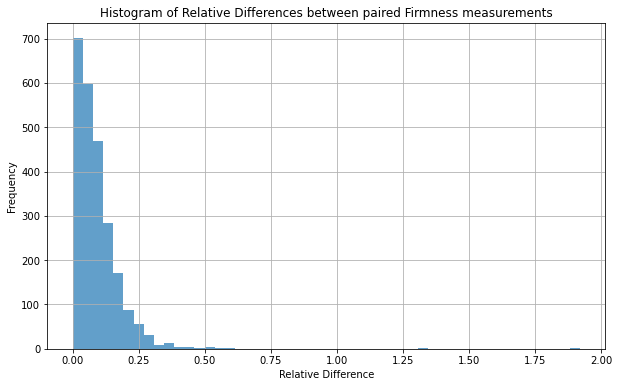

50th percentile: 0.0719
75th percentile: 0.1233
90th percentile: 0.1824
95th percentile: 0.2337
99th percentile: 0.3541


In [8]:
plot_relative_differences(rel_diffs)

50th percentile (median) ~7.2%: 50% differ by less than ~7.2%.

75th percentile ~12.3%: 75% differ less than ~12.3%.

90th percentile ~18.2%

95th percentile ~23.4%

99th percentile ~35.4%

In [9]:
import pandas as pd

def process_group(group: pd.DataFrame, threshold: float = 0.05) -> pd.Series:
    if len(group) == 2:
        val1, val2 = group['Firmness (kg)'].values
        diff = abs(val1 - val2)
        avg_val = (val1 + val2) / 2
        rel_diff = diff / avg_val if avg_val != 0 else 0
        outlier_flag = rel_diff > threshold
        source_indices = group.index.tolist()
        source_str = "_".join(str(idx) for idx in source_indices)
        row = group.iloc[0].copy()
        row['Firmness (kg)'] = avg_val
        row['outlier_flag'] = outlier_flag
        row['rel_diff'] = rel_diff              # <-- add this line
        row['source_rows'] = f"avg_{source_str}"
    else:
        avg_val = group['Firmness (kg)'].mean()
        source_indices = group.index.tolist()
        source_str = "_".join(str(idx) for idx in source_indices)
        row = group.iloc[0].copy()
        row['Firmness (kg)'] = avg_val
        row['outlier_flag'] = True
        row['rel_diff'] = None                   # <-- add this line
        row['source_rows'] = f"avg_{source_str}"

    return row


def average_with_outlier_flag(df: pd.DataFrame, threshold: float = 0.20) -> pd.DataFrame:
    """
    Group by Experiment, TestDate, Fruit nr, Size, and Weight,
    average measurements if there are two values and their relative difference is within a threshold,
    otherwise flag them as outliers.

    Parameters:
    - df: Input DataFrame with 'Firmness (kg)' measurements
    - threshold: Relative difference threshold to flag outliers (default 0.05)

    Returns:
    - DataFrame with averaged rows, outlier flag, and traceable unique source IDs
    """
    grouped = df.groupby(['Experiment', 'TestDate', 'Fruit nr', 'Size', 'Weight'], group_keys=False)
    result_df = grouped.apply(process_group, threshold=threshold).reset_index(drop=True)

    # Add a unique numerical ID as well
    result_df = result_df.reset_index(drop=True)
    result_df['unique_id'] = result_df.index + 1

    return result_df

def process_firmness_measurements(df: pd.DataFrame) -> pd.DataFrame:
    """
    Kedro node wrapper function to process firmness measurements.
    """
    return average_with_outlier_flag(df)


In [10]:
result_df = average_with_outlier_flag(denoised_df, threshold=0.20)

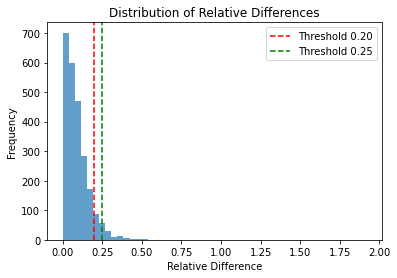

In [11]:
import matplotlib.pyplot as plt

plt.hist(result_df['rel_diff'].dropna(), bins=50, alpha=0.7)
plt.axvline(0.20, color='red', linestyle='--', label='Threshold 0.20')
plt.axvline(0.25, color='green', linestyle='--', label='Threshold 0.25')
plt.legend()
plt.xlabel('Relative Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Differences')
plt.show()


In [12]:
averaged_df = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/02_intermediate/averaged_data.csv")

In [15]:
averaged_df['firmness_outlier_flag'].value_counts()

False    2246
True      191
Name: firmness_outlier_flag, dtype: int64

Duplicates found: 0


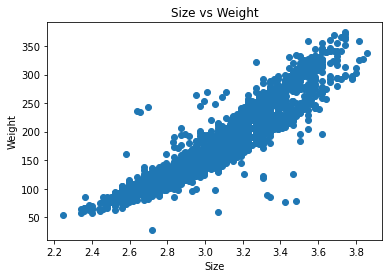

           sensorT  Firmness (kg)         Brix          TA         Size  \
count  2437.000000    2437.000000  2437.000000  2437.00000  2437.000000   
mean     53.113500       7.593687    13.400837     0.43538     3.067679   
std       2.567712       1.346746     0.803810     0.14856     0.290114   
min      42.461655       2.775529     9.000000     0.02350     2.244088   
25%      51.940879       6.621309    12.900000     0.30700     2.834637   
50%      53.631019       7.636448    13.400000     0.44910     3.070857   
75%      54.760765       8.606455    13.900000     0.54500     3.270000   
max      56.740809      11.466806    17.200000     0.99230     3.858256   

            Weight  
count  2437.000000  
mean    179.065654  
std      64.856743  
min      28.000000  
25%     128.000000  
50%     170.000000  
75%     224.000000  
max     374.000000  


In [20]:
# Check for duplicates
duplicates = averaged_df.duplicated()
print(f"Duplicates found: {duplicates.sum()}")

# Example: Check if Weight roughly correlates with Size (basic sanity check)
import matplotlib.pyplot as plt
plt.scatter(averaged_df['Size'], averaged_df['Weight'])
plt.xlabel('Size')
plt.ylabel('Weight')
plt.title('Size vs Weight')
plt.show()

# Check ranges
print(averaged_df[['sensorT', 'Firmness (kg)', 'Brix', 'TA', 'Size', 'Weight']].describe())


In [16]:
hybrid_outlier_df = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/02_intermediate/hybrid_outlier_flagged_data.csv") 

In [18]:
hybrid_outlier_df['iforest_outlier_flag'].value_counts()

False    2315
True      122
Name: iforest_outlier_flag, dtype: int64

In [19]:
hybrid_outlier_df['final_outlier_flag'].value_counts()

False    2127
True      310
Name: final_outlier_flag, dtype: int64

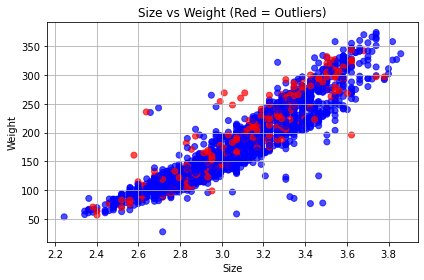

In [21]:
import matplotlib.pyplot as plt

# Create color labels based on final_outlier_flag
colors = hybrid_outlier_df['final_outlier_flag'].map({True: 'red', False: 'blue'})

# Scatter plot with conditional coloring
plt.figure(figsize=(6, 4))
plt.scatter(hybrid_outlier_df['Size'], hybrid_outlier_df['Weight'], c=colors, alpha=0.7)
plt.xlabel('Size')
plt.ylabel('Weight')
plt.title('Size vs Weight (Red = Outliers)')
plt.grid(True)
plt.tight_layout()
plt.show()


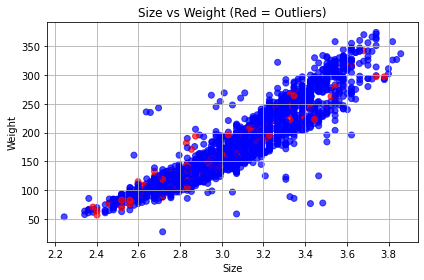

In [24]:
import matplotlib.pyplot as plt

# Create color labels based on firmness_outlier_flag
colors = hybrid_outlier_df['firmness_outlier_flag'].map({True: 'red', False: 'blue'})

# Scatter plot with conditional coloring
plt.figure(figsize=(6, 4))
plt.scatter(hybrid_outlier_df['Size'], hybrid_outlier_df['Weight'], c=colors, alpha=0.7)
plt.xlabel('Size')
plt.ylabel('Weight')
plt.title('Size vs Weight (Red = Outliers)')
plt.grid(True)
plt.tight_layout()
plt.show()


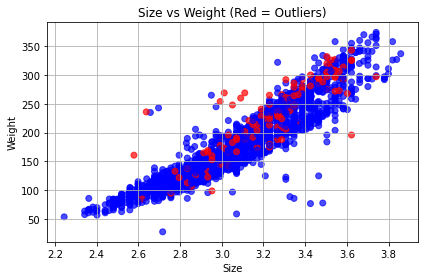

In [23]:
import matplotlib.pyplot as plt

# Create color labels based on iforest_outlier_flag
colors = hybrid_outlier_df['iforest_outlier_flag'].map({True: 'red', False: 'blue'})

# Scatter plot with conditional coloring
plt.figure(figsize=(6, 4))
plt.scatter(hybrid_outlier_df['Size'], hybrid_outlier_df['Weight'], c=colors, alpha=0.7)
plt.xlabel('Size')
plt.ylabel('Weight')
plt.title('Size vs Weight (Red = Outliers)')
plt.grid(True)
plt.tight_layout()
plt.show()


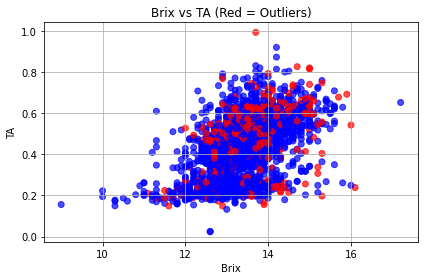

In [70]:
# Create color labels based on iforest_outlier_flag
colors = hybrid_outlier_df['final_outlier_flag'].map({True: 'red', False: 'blue'})

# Scatter plot with conditional coloring
plt.figure(figsize=(6, 4))
plt.scatter(hybrid_outlier_df['Brix'], hybrid_outlier_df['TA'], c=colors, alpha=0.7)
plt.xlabel('Brix')
plt.ylabel('TA')
plt.title('Brix vs TA (Red = Outliers)')
plt.grid(True)
plt.tight_layout()
plt.show()

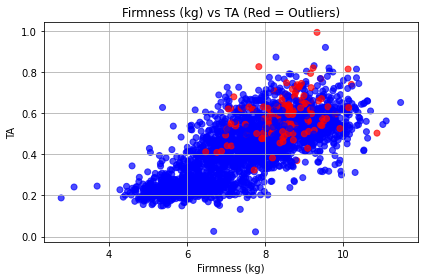

In [72]:
# Create color labels based on iforest_outlier_flag
colors = hybrid_outlier_df['iforest_outlier_flag'].map({True: 'red', False: 'blue'})

# Scatter plot with conditional coloring
plt.figure(figsize=(6, 4))
plt.scatter(hybrid_outlier_df['Firmness (kg)'], hybrid_outlier_df['TA'], c=colors, alpha=0.7)
plt.xlabel('Firmness (kg)')
plt.ylabel('TA')
plt.title('Firmness (kg) vs TA (Red = Outliers)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Outlier Detection: Hybrid Approach Justification

### Firmness Difference Flag (Univariate):
Targets inconsistencies in key measurement (firmness) by comparing repeated measures.

Detects measurement errors or anomalies directly affecting fruit quality assessment.

### Isolation Forest (Multivariate):
Detects unusual samples based on all features (spectral + scalar) using unsupervised learning.

Captures complex, multivariate anomalies invisible to univariate methods.

### Why keep both?

Only ~3 samples overlap between methods — they detect mostly distinct outliers.

Combining flags (logical OR) maximizes anomaly detection coverage:

Catches both measurement inconsistencies and spectral/feature anomalies.

Provides a robust framework given limited domain knowledge, minimizing overlooked outliers.

Supporting evidence:

Firmness outliers show more normal distribution, Isolation Forest outliers are right-skewed.

Because these methods complement each other, using both provides a more robust outlier detection framework. It balances sensitivity to both univariate measurement errors and multivariate spectral anomalies.

This hybrid approach reduces the risk of missing critical outliers that could bias your modeling or correlation analysis.

In [93]:
denoised_df[['sensorT', 'Firmness (kg)', 'Brix', 'TA']].corr()

,sensorT,Firmness (kg),Brix,TA
sensorT,1.000000,0.002777,-0.091741,0.056972
Firmness (kg),0.002777,1.000000,0.466716,0.696871
Brix,-0.091741,0.466716,1.000000,0.495151
TA,0.056972,0.696871,0.495151,1.000000


In [94]:
averaged[['sensorT', 'Firmness (kg)', 'Brix', 'TA']].corr()

,sensorT,Firmness (kg),Brix,TA
sensorT,1.000000,0.002947,-0.091742,0.057000
Firmness (kg),0.002947,1.000000,0.490518,0.732407
Brix,-0.091742,0.490518,1.000000,0.495151
TA,0.057000,0.732407,0.495151,1.000000


Sensor temperature (sensorT) was evaluated as a potential influencing factor on target variables (Firmness, Brix, TA) and multivariate outlier detection. Correlation analysis and Isolation Forest modeling both showed negligible impact. Therefore, sensorT is not considered a significant source of variability in the current dataset.

In [25]:
denoised_df[['sensorT', 'Weight', 'Size', 'Firmness (kg)', 'Brix', 'TA']].corr()

,sensorT,Weight,Size,Firmness (kg),Brix,TA
sensorT,1.000000,-0.055383,-0.079749,0.002868,-0.091673,0.056972
Weight,-0.055383,1.000000,0.925838,0.419396,0.407694,0.538970
Size,-0.079749,0.925838,1.000000,0.338529,0.342995,0.506736
Firmness (kg),0.002868,0.419396,0.338529,1.000000,0.466684,0.696871
Brix,-0.091673,0.407694,0.342995,0.466684,1.000000,0.495151
TA,0.056972,0.538970,0.506736,0.696871,0.495151,1.000000


Weight and Size are strongly correlated (0.93) – which makes sense physically.

Target variables (Firmness, Brix, TA) are moderately to strongly correlated with each other, especially:

Firmness vs TA: 0.70

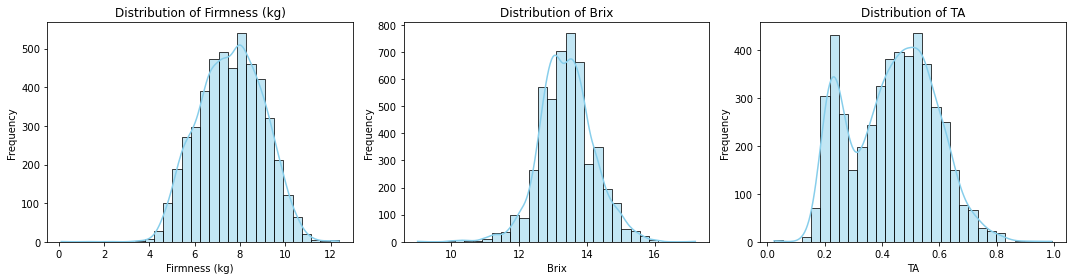

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df and contains cleaned data:
cols = ['Firmness (kg)', 'Brix', 'TA']

plt.figure(figsize=(15, 4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(denoised_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


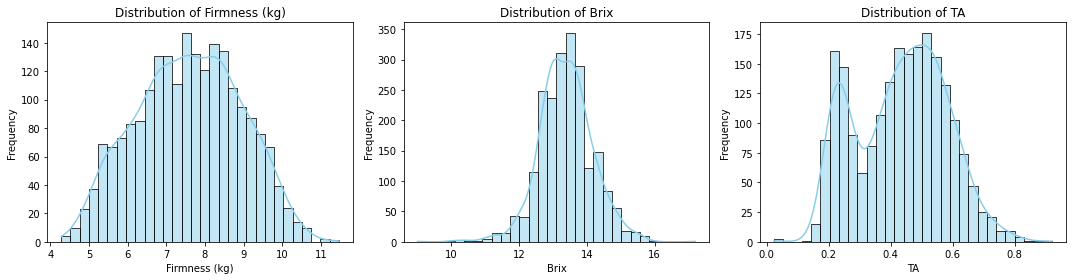

In [75]:
plt.figure(figsize=(15, 4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(filtered_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

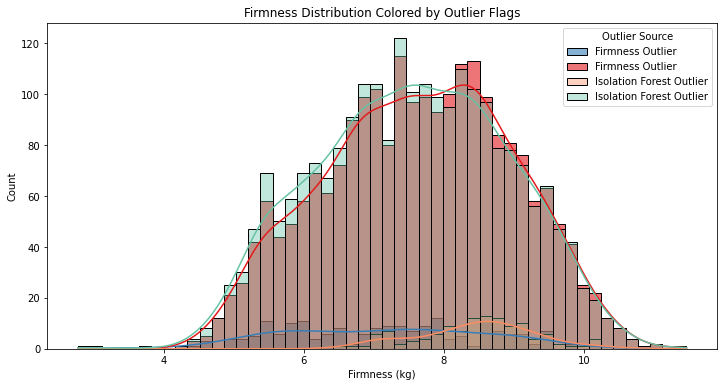

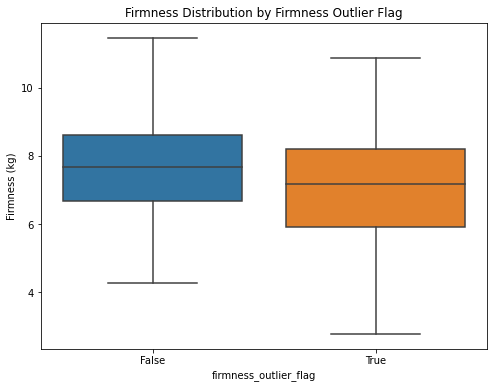

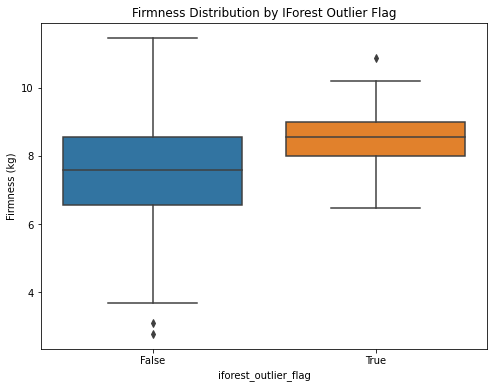

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a combined flag column to visualize overlap
hybrid_outlier_df['outlier_combined'] = hybrid_outlier_df['firmness_outlier_flag'] | hybrid_outlier_df['iforest_outlier_flag']

# Plot histogram of firmness colored by outlier flags
plt.figure(figsize=(12,6))
sns.histplot(data=hybrid_outlier_df, x='Firmness (kg)', hue='firmness_outlier_flag', bins=50, kde=True, palette='Set1', alpha=0.6, label='Firmness Outlier')
sns.histplot(data=hybrid_outlier_df, x='Firmness (kg)', hue='iforest_outlier_flag', bins=50, kde=True, palette='Set2', alpha=0.4, label='Isolation Forest Outlier')
plt.title('Firmness Distribution Colored by Outlier Flags')
plt.legend(title='Outlier Source')
plt.show()

# Boxplot for clearer comparison
plt.figure(figsize=(8,6))
sns.boxplot(x='firmness_outlier_flag', y='Firmness (kg)', data=hybrid_outlier_df)
plt.title('Firmness Distribution by Firmness Outlier Flag')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='iforest_outlier_flag', y='Firmness (kg)', data=hybrid_outlier_df)
plt.title('Firmness Distribution by IForest Outlier Flag')
plt.show()


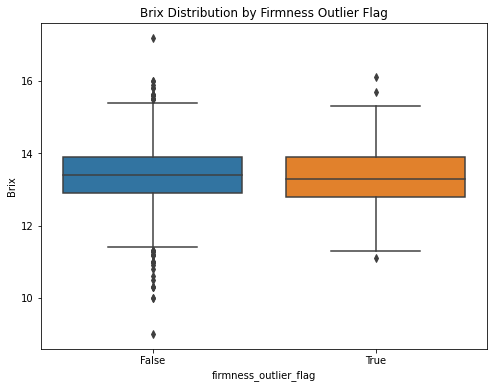

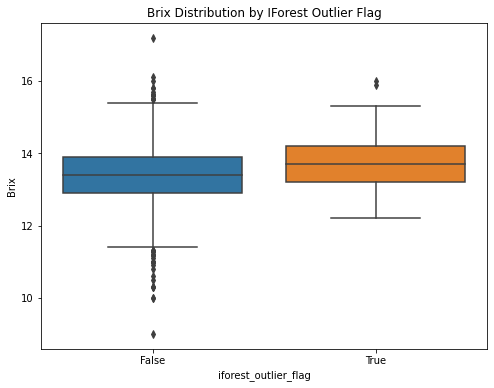

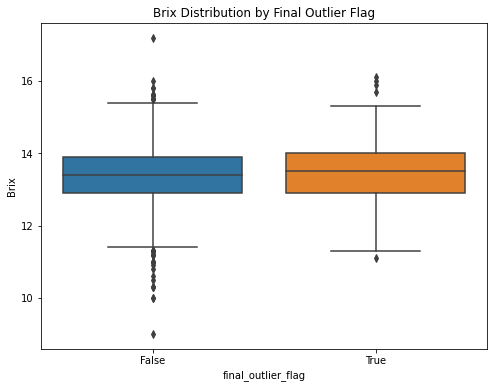

In [28]:
# Boxplot for clearer comparison
plt.figure(figsize=(8,6))
sns.boxplot(x='firmness_outlier_flag', y='Brix', data=hybrid_outlier_df)
plt.title('Brix Distribution by Firmness Outlier Flag')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='iforest_outlier_flag', y='Brix', data=hybrid_outlier_df)
plt.title('Brix Distribution by IForest Outlier Flag')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='final_outlier_flag', y='Brix', data=hybrid_outlier_df)
plt.title('Brix Distribution by Final Outlier Flag')
plt.show()

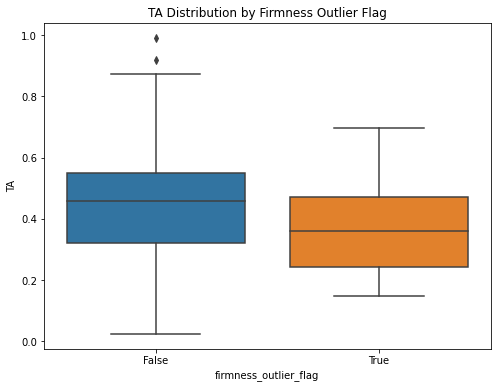

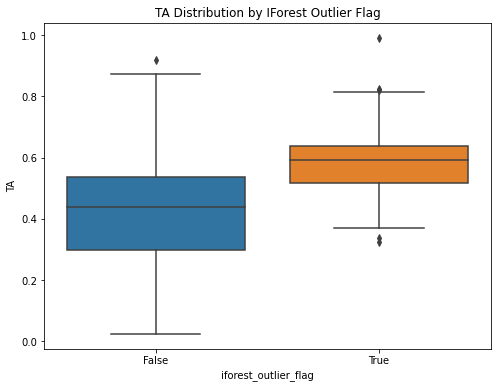

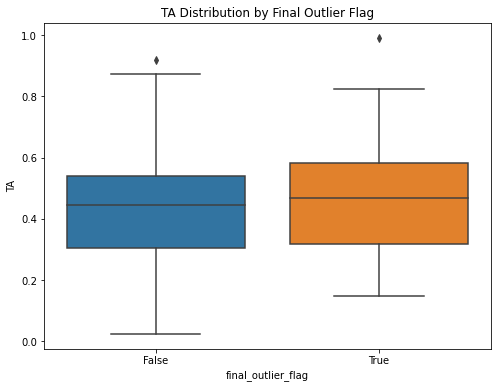

In [29]:
# Boxplot for clearer comparison
plt.figure(figsize=(8,6))
sns.boxplot(x='firmness_outlier_flag', y='TA', data=hybrid_outlier_df)
plt.title('TA Distribution by Firmness Outlier Flag')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='iforest_outlier_flag', y='TA', data=hybrid_outlier_df)
plt.title('TA Distribution by IForest Outlier Flag')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='final_outlier_flag', y='TA', data=hybrid_outlier_df)
plt.title('TA Distribution by Final Outlier Flag')
plt.show()

In [73]:
filtered = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/02_intermediate/filtered_data.csv")

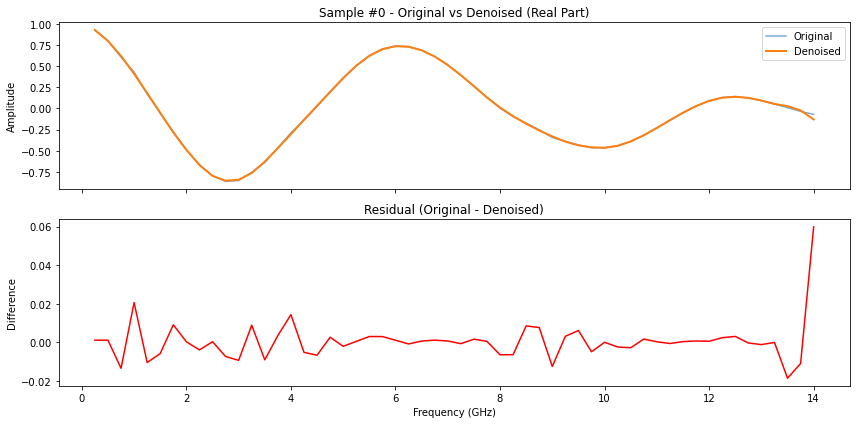

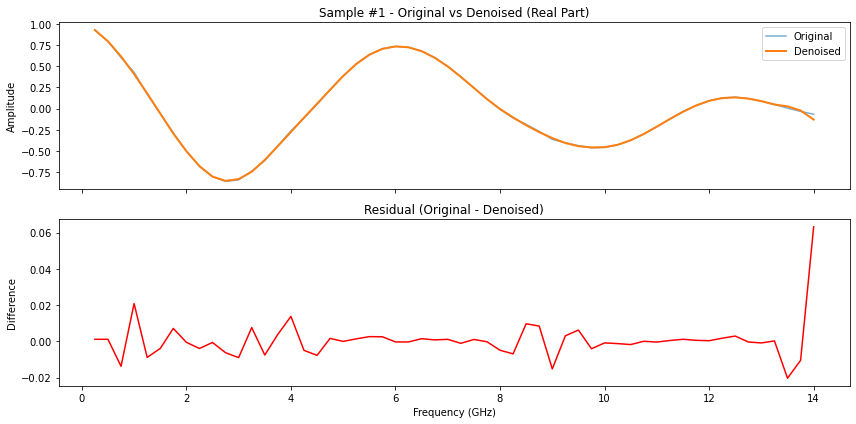

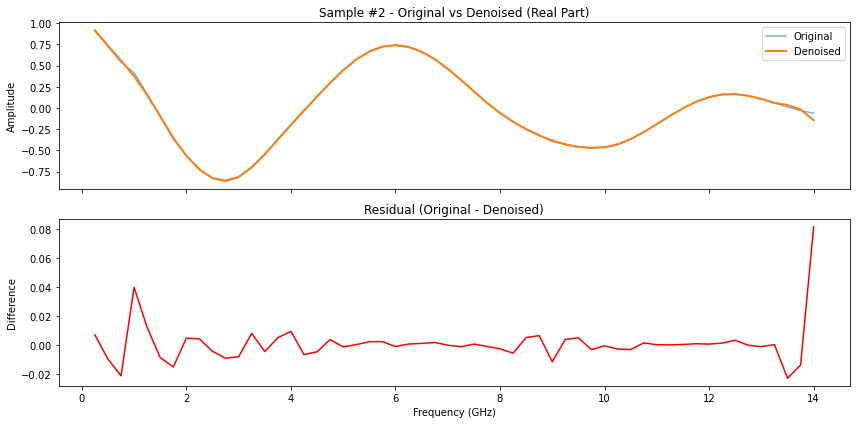

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Choose some sample indices to plot
sample_indices = [0, 1, 2]  # change as needed

for idx in sample_indices:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    
    # Select columns for real parts
    real_cols = [col for col in raw_df.columns if '_GHz_real' in col]
    freqs = [float(col.split('_')[0]) for col in real_cols]
    
    # Extract data
    original = raw_df.loc[idx, real_cols].values
    denoised_vals = denoised_df.loc[idx, real_cols].values
    
    # Plot original and denoised on first subplot
    ax1.plot(freqs, original, label='Original', alpha=0.6)
    ax1.plot(freqs, denoised_vals, label='Denoised', linewidth=2)
    ax1.set_title(f'Sample #{idx} - Original vs Denoised (Real Part)')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    
    # Plot difference (residual) on second subplot
    residual = original - denoised_vals
    ax2.plot(freqs, residual, color='red')
    ax2.set_title('Residual (Original - Denoised)')
    ax2.set_xlabel('Frequency (GHz)')
    ax2.set_ylabel('Difference')
    
    plt.tight_layout()
    plt.show()


In [34]:
filtered_df = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/02_intermediate/filtered_data.csv")

In [47]:
import numpy as np

def compute_high_correlations(df: pd.DataFrame, target: str, threshold: float = 0.5) -> pd.Series:
    spectral_cols = [col for col in df.columns if "GHz" in col]
    correlations = df[spectral_cols].corrwith(df[target])
    high_corr = correlations[correlations.abs() >= threshold].sort_values(ascending=False)
    return high_corr


In [48]:
compute_high_correlations(filtered_df, "TA")

1.25_GHz_imag    0.534378
dtype: float64

In [49]:
compute_high_correlations(filtered_df, "Brix")

Series([], dtype: float64)

In [50]:
compute_high_correlations(filtered_df, "Firmness (kg)")

1.25_GHz_imag    0.586618
dtype: float64

In [43]:
magphase_df = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/02_intermediate/magphase_data.csv")

In [52]:
compute_high_correlations(magphase_df, "TA")

Series([], dtype: float64)

In [53]:
compute_high_correlations(magphase_df, "Brix")

Series([], dtype: float64)

In [54]:
compute_high_correlations(magphase_df, "Firmness (kg)")

Series([], dtype: float64)

In [57]:
Xtrain_pca = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/03_primary/X_train_pca.csv")
labels = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/03_primary/train_labels.csv")
pca_df = pd.concat([Xtrain_pca, labels], axis=1)

In [58]:
compute_high_correlations(pca_df, "TA")

/var/folders/d9/38v73pvj0b78yjdkfpdv_l_w0000gn/T/ipykernel_73034/3612829548.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  correlations = df[spectral_cols].corrwith(df[target])


Series([], dtype: float64)

In [59]:
compute_high_correlations(pca_df, "Brix")

/var/folders/d9/38v73pvj0b78yjdkfpdv_l_w0000gn/T/ipykernel_73034/3612829548.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  correlations = df[spectral_cols].corrwith(df[target])


Series([], dtype: float64)

In [60]:
compute_high_correlations(pca_df, "Firmness (kg)")

/var/folders/d9/38v73pvj0b78yjdkfpdv_l_w0000gn/T/ipykernel_73034/3612829548.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  correlations = df[spectral_cols].corrwith(df[target])


Series([], dtype: float64)

In [67]:
X_train = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/03_primary/train_data.csv")
y = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/03_primary/test_labels.csv")

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume: X_denoised (DataFrame of denoised features), y (DataFrame of targets)
corr_matrix = pd.concat([X_train, y], axis=1).corr()
feature_target_corr = corr_matrix.loc[X_train.columns, y.columns]

# Find features with |corr| > threshold (e.g., 0.3)
threshold = 0.3
for target in y.columns:
    print(f"\nFeatures correlated with {target}:")
    correlated_feats = feature_target_corr[target].abs() > threshold
    selected_features = feature_target_corr.index[correlated_feats].tolist()
    print(selected_features)
    
    for feat in selected_features:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        sns.histplot(X_train[feat], kde=True)
        plt.title(f'Histogram of feature {feat}')
        
        plt.subplot(1,2,2)
        sns.scatterplot(x=X_train[feat], y=y[target])
        plt.title(f'Scatter plot of {feat} vs {target}')
        plt.show()



Features correlated with Firmness (kg):
[]

Features correlated with Brix:
[]

Features correlated with TA:
[]


In [69]:
import pickle
import pandas as pd

# Load the saved model dictionary
with open("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/06_models/regression_models.pkl", "rb") as f:
    xgb_models_dict = pickle.load(f)

# Iterate through each model and print feature names and importances
for target_name, model in xgb_models_dict.items():
    print(f"\n🔍 Target: {target_name}")
    
    # Try to get feature names from sklearn interface
    if hasattr(model, "feature_names_in_"):
        features = model.feature_names_in_
    else:
        # Try to get feature names from booster
        booster = model.get_booster()
        if booster.feature_names:
            features = booster.feature_names
        else:
            print("⚠️ Feature names not available for this model.")
            continue

    # Get feature importances
    importance = model.feature_importances_
    
    # Create and display a sorted DataFrame
    feature_df = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values(by="importance", ascending=False)

    print(feature_df.to_string(index=False))


[10:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[10:07:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differenc

In [73]:
scaled_df = pd.read_csv("/Users/banubilmez/spectral-data-analysis/spectral-data-analysis/data/03_primary/X_train_scaled.csv")
scaled_df.shape

(1701, 112)